# 2-Cell and 3-Cell Motifs in PyC Subgraph (Th=0)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.proximity import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

### 1. Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [5]:
g_th0 = get_thresholded_graph(g_actual, axls, 0)
print(nx.info(g_th0))

Name: 
Type: DiGraph
Number of nodes: 227
Number of edges: 1257
Average in degree:   5.5374
Average out degree:   5.5374


### 2. Compare 2-Cell Motif Statistics (OBS vs ER vs CFG)

In [6]:
%%time
# count 2-cell motifs in the observation
obs_two_counts = count_two_neuron_motifs_graph(g_th0)
# analytically compute 2-cell motif counts in Erdos-Renyi model
er_two_counts = compute_ER_two_neuron_motifs(g_th0)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.77 ms


In [7]:
%%time
# sample graphs from CFG model and compute 2-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_two_counts = sample_motifs_parallel_continuous(continuous_sample_two_neuron_motifs, g_th0, samples=s, niters=int(1e4), threads=10)

CPU times: user 104 ms, sys: 52 ms, total: 156 ms
Wall time: 1min 3s


In [8]:
# save sampled motif counts from CFG model as intermediate data
config_two_counts.to_csv("saved/th0_2motif_cfg1000.csv", index=False)

In [9]:
# load precomputed sampled motif counts from CFG model
config_two_counts = pd.read_csv("saved/th0_2motif_cfg1000.csv")

connect probability =  0.02450196873416241


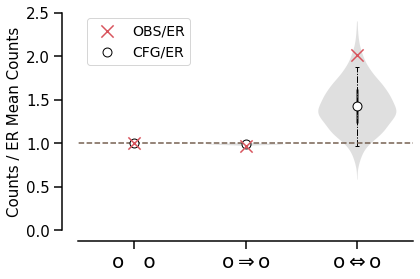

In [43]:
# relative counts in ratio (/ER expected counts)
res_two = plot_two_neuron_counts_violin(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 2.5), fname="th0/th0_2_violin");

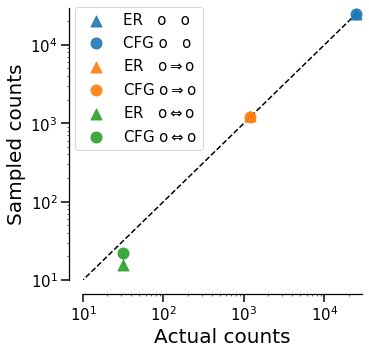

In [11]:
plot_two_neuron_counts_scatter(obs_two_counts, er_two_counts, config_two_counts, figsize=(5,5), fname="th0/th0_2_scatter")

In [12]:
res_two

,obs,er_exp,config_exp,config_std,proximity_z
actual_edges,NaN,NaN,1257.000,0.000000,NaN
autapses,NaN,NaN,0.000,0.000000,NaN
bi,31.0,15.399487,22.028,4.327348,2.073325
neurons,NaN,NaN,227.000,0.000000,NaN
null,24425.0,24409.399487,24416.028,4.327348,2.073325
potential_edges,NaN,NaN,51302.000,0.000000,NaN
uni,1195.0,1226.201025,1212.944,8.654696,-2.073325


In [14]:
# single side p-values
np.minimum((config_two_counts >= obs_two_counts).sum(0) / 1000, 
           (config_two_counts <= obs_two_counts).sum(0) / 1000)

neurons            1.000
autapses           1.000
actual_edges       1.000
uni                0.034
bi                 0.034
potential_edges    1.000
null               0.034
dtype: float64

### 2. Compare 3-Cell Motif Statistics (OBS vs gER vs CFG)

In [20]:
%%time
# count 3-cell motifs in the observation
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(g_th0), motifs)
# analytically compute 2-cell motif counts in generalized Erdos-Renyi model
three_pr_GE, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th0)
er_three_counts_GE = compute_expected_three_neuron_motifs(g_th0, three_pr_GE)

CPU times: user 59.9 s, sys: 88 ms, total: 1min
Wall time: 1min


In [21]:
%%time
# sample graphs from CFG model and compute 3-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs, g_th0, samples=s, niters=int(1e4), threads=10)

CPU times: user 244 ms, sys: 128 ms, total: 372 ms
Wall time: 3h 8min 34s


In [22]:
# save sampled motif counts from CFG model as intermediate data
config_three_counts.to_csv("saved/th0_3motif_cfg1000.csv", index=False)

In [23]:
# load precomputed sampled motif counts from CFG model
config_three_counts = pd.read_csv("saved/th0_3motif_cfg1000.csv")
config_three_counts.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

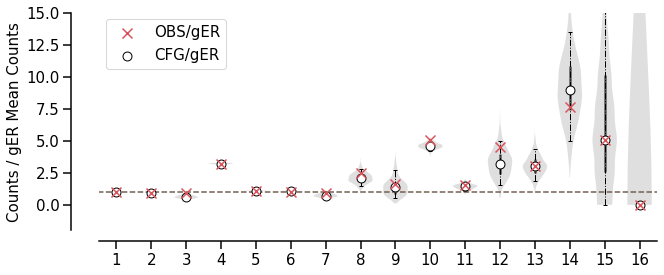

In [44]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                            subtitle='', ylim=[-2, 15], er_name="gER", fname="th0/th0_3_violin", figsize=(10,4))

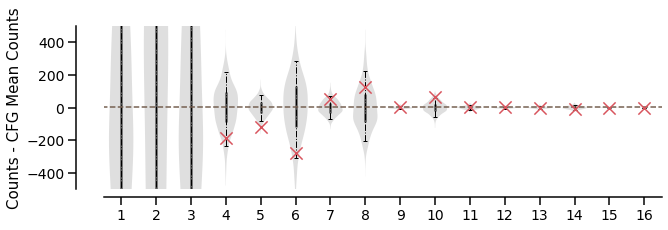

In [25]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                     subtitle='', ylim=[-500, 500], er_name="gER", fname="th0/th0_3_violin_diff");

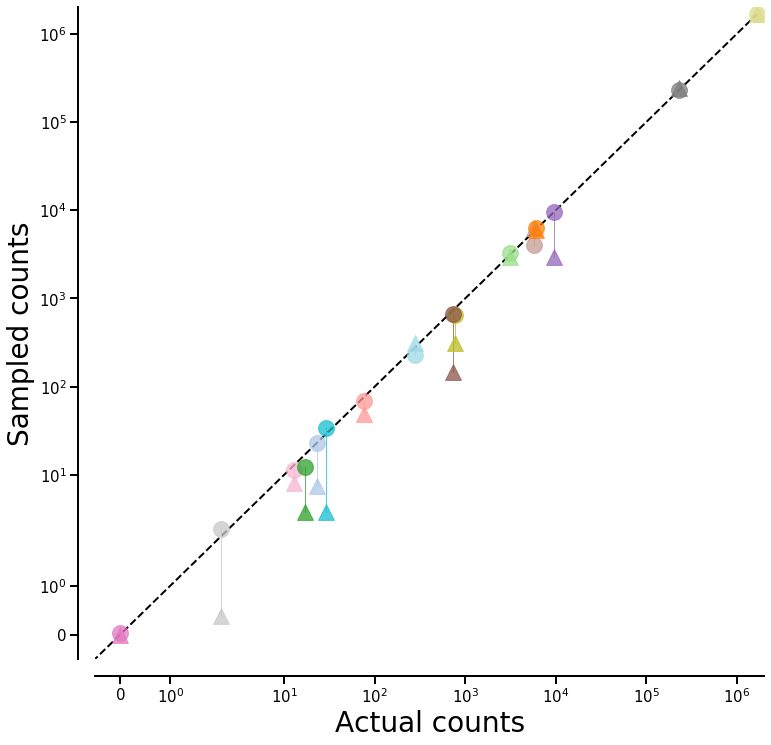

In [26]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts, figsize=(12,12), fname="th0/th0_3_scatter")

In [27]:
res_three

,obs,er_exp,config_exp,config_std,config_z
1,1669417,1.660949e+06,1667664.334,780.041754,2.246887
2,228030,2.437872e+05,231286.444,1397.743380,-2.329787
3,5818,6.324188e+03,3979.652,792.202431,2.320553
4,9434,2.981840e+03,9617.311,136.584881,-1.342103
5,3154,2.981840e+03,3275.456,50.166889,-2.421039
6,6019,5.963680e+03,6297.943,183.688250,-1.518567
7,280,3.094127e+02,226.550,44.151454,1.210606
8,778,3.094127e+02,652.551,130.468799,0.961525
9,13,8.026605e+00,11.295,5.597795,0.304584
10,735,1.458874e+02,671.389,35.523705,1.790663


In [28]:
# one side p-values
np.minimum((config_three_counts >= obs_three_counts).sum(0) / 1000, 
           (config_three_counts <= obs_three_counts).sum(0) / 1000)

1     0.017
2     0.013
3     0.013
4     0.089
5     0.007
6     0.071
7     0.124
8     0.166
9     0.373
10    0.039
11    0.273
12    0.159
13    0.526
14    0.314
15    0.562
16    0.971
dtype: float64

### 4. Clustering Coefficient

In [35]:
# compute connection probability in ER
three_pr, two_pr = compute_three_neuron_motif_probabilities(g_th0)

In [45]:
%%time
# sample graphs from generalized CFG (gCFG) model and compute 3-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts_GE = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs_GE, g_th0, samples=s, niters=int(1e4), threads=10)

CPU times: user 252 ms, sys: 136 ms, total: 388 ms
Wall time: 3h 14min 47s


In [46]:
# save sampled motif counts from gCFG model as intermediate data
config_three_counts_GE.to_csv("saved/th0_3motif_gcfg1000.csv", index=False)

In [47]:
# load precomputed sampled motif counts from gCFG model
config_three_counts_GE = pd.read_csv("saved/th0_3motif_gcfg1000.csv")
config_three_counts_GE.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

In [48]:
# clustering coefficient of the observed network
nx.transitivity(g_th0.to_undirected())

0.1185271456728185

In [49]:
# expected clustering coefficient of the networsk sampled from the ER model
1-two_pr['pr_null']

0.048403590996474954

In [50]:
# expected clustering coefficient of the networsk sampled from the CFG model
clustering_coef(config_three_counts).mean()

0.10835003702001293

In [51]:
# expected clustering coefficient of the networsk sampled from the generalized ER model
1-two_pr_GE['pr_null']

0.047795407586448846

In [52]:
# expected clustering coefficient of the networsk sampled from the generalized CFG model
clustering_coef(config_three_counts_GE).mean()

0.1062683118895982

In [53]:
# p-value: CFG vs OBS
(clustering_coef(config_three_counts) >= nx.transitivity(g_th0.to_undirected())).sum()/1000

0.002

### 5. Generate Smaller Plots for Pannels

connect probability =  0.02450196873416241


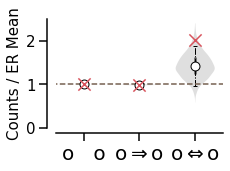

In [38]:
plot_two_neuron_counts_violin_adapt(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 2.5), figsize=(3,2), fname="th0/th0_2_violin");

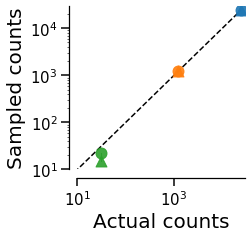

In [39]:
plot_two_neuron_counts_scatter_adapt(obs_two_counts, er_two_counts, config_two_counts, figsize=(3,3), fname="th0/th0_2_scatter");

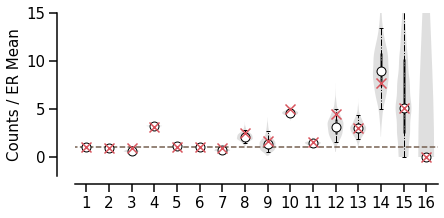

In [40]:
res_three_CGE = plot_three_neuron_counts_violin_adapt(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                            subtitle='', ylim=[-2, 15], fname="th0/th0_3_violin_CGE", figsize=(6.5,3))

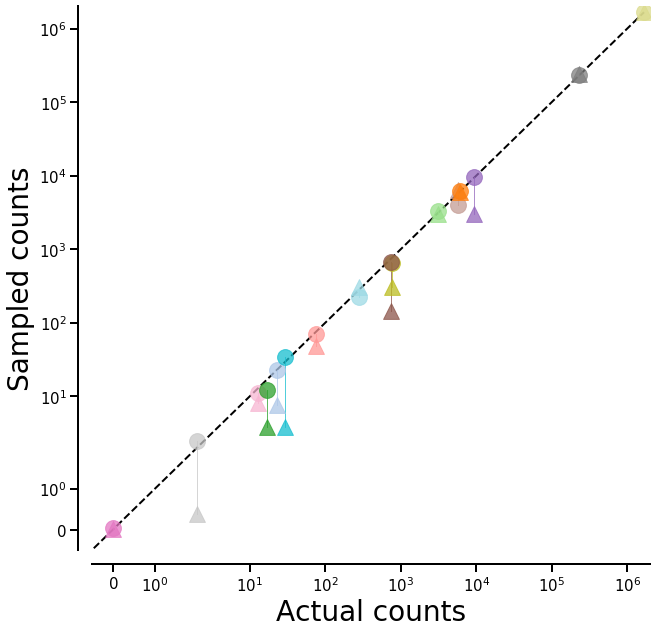

In [41]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                 figsize=(10,10), fname="th0/th0_3_scatter_CGE")